## Past data and Forecast 1,3,7,14,16 days

In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt
from weather_forecast import getWeatherForecast, fetch_past_weather_data

In [2]:
DATA_FOLDER_PATH = os.getcwd() + '/../data/KS VERI/'
FILE_NAME = 'KS10_MASTER_DATA.xlsx'
PATH = DATA_FOLDER_PATH + FILE_NAME

In [3]:
START_TIME = pd.to_datetime('2023-01-01 00:00:00')
END_TIME = pd.to_datetime('2023-11-10 23:55:00')
TIMESTAMPS = [str(time) for time in pd.date_range(START_TIME, END_TIME, freq='5min')]

In [4]:
OUTLET_WEATHER_DATA = pd.DataFrame(columns=['Timestamp',
                                            'Temperature',
                                            'Humidity'])
OUTLET_WEATHER_DATA['Timestamp'] = TIMESTAMPS
OUTLET_WEATHER_DATA['Timestamp'] = pd.to_datetime(OUTLET_WEATHER_DATA['Timestamp'])

# add one more day before the first timestamp for every 5 minutes
start_date = pd.Timestamp(str(TIMESTAMPS[0]).split(' ')[0]) - pd.Timedelta(days=1)
for i in range(0, 288):
    new_timestamp = start_date + pd.Timedelta(minutes=5*i)
    OUTLET_WEATHER_DATA.loc[len(OUTLET_WEATHER_DATA)] = [new_timestamp, None, None]
    
OUTLET_WEATHER_DATA = OUTLET_WEATHER_DATA.sort_values(by=['Timestamp'])
OUTLET_WEATHER_DATA = OUTLET_WEATHER_DATA.reset_index(drop=True)
OUTLET_WEATHER_DATA

,Timestamp,Temperature,Humidity
0,2022-12-31 00:00:00,NaN,NaN
1,2022-12-31 00:05:00,NaN,NaN
2,2022-12-31 00:10:00,NaN,NaN
3,2022-12-31 00:15:00,NaN,NaN
4,2022-12-31 00:20:00,NaN,NaN
...,...,...,...
90715,2023-11-10 23:35:00,NaN,NaN
90716,2023-11-10 23:40:00,NaN,NaN
90717,2023-11-10 23:45:00,NaN,NaN
90718,2023-11-10 23:50:00,NaN,NaN


In [5]:
DDstart_date = pd.Timestamp(TIMESTAMPS[0].split(' ')[0]) - pd.Timedelta(days=1)
end_date = pd.Timestamp(TIMESTAMPS[-1].split(' ')[0]) + pd.Timedelta(days=1)

WEATHER_DATA_FROM_API = fetch_past_weather_data(start_date.date(),
                                                end_date.date(), 
                                                "hourly")
WEATHER_DATA_FROM_API

Coordinates 41.01932907104492°E 28.887304306030273°N
Timezone b'Europe/Moscow' b'MSK'


,date,temperature,relative_humidity
0,2022-12-30 22:00:00,7.395500,90.518997
1,2022-12-30 23:00:00,7.645500,90.537018
2,2022-12-31 00:00:00,7.495500,90.839195
3,2022-12-31 01:00:00,7.695500,89.608734
4,2022-12-31 02:00:00,7.945500,87.793236
...,...,...,...
7579,2023-11-11 17:00:00,18.195499,83.991875
7580,2023-11-11 18:00:00,18.195499,83.723022
7581,2023-11-11 19:00:00,17.445499,89.473663
7582,2023-11-11 20:00:00,18.345499,85.363205


In [6]:
# for every timestamp in the outlet data, find the closest timestamp in the weather data
# and get the weather data for that timestamp

for index, row in OUTLET_WEATHER_DATA.iterrows():
    timestamp = row['Timestamp']
    date = timestamp.date()
    time = timestamp.time()
    
    print(date, time)
    
    # if time is in the first half of the hour, round down to the previous hour
    if time.minute < 30:
        timestamp = pd.Timestamp(date.year, date.month, date.day, time.hour, 0, 0)
    # if time is in the second half of the hour, round up to the next hour
    else:
        timestamp = pd.Timestamp(date.year, date.month, date.day, time.hour, 0, 0) + pd.Timedelta(hours=1)
        
    # find the timestamp in the weather data
    temperature = WEATHER_DATA_FROM_API[WEATHER_DATA_FROM_API['date'] == timestamp]['temperature'].values[0]
    humidity = WEATHER_DATA_FROM_API[WEATHER_DATA_FROM_API['date'] == timestamp]['relative_humidity'].values[0]
    
    OUTLET_WEATHER_DATA.loc[index, 'Temperature'] = temperature
    OUTLET_WEATHER_DATA.loc[index, 'Humidity'] = humidity
    
OUTLET_WEATHER_DATA

2022-12-31 00:00:00
2022-12-31 00:05:00
2022-12-31 00:10:00
2022-12-31 00:15:00
2022-12-31 00:20:00
2022-12-31 00:25:00
2022-12-31 00:30:00
2022-12-31 00:35:00
2022-12-31 00:40:00
2022-12-31 00:45:00
2022-12-31 00:50:00
2022-12-31 00:55:00
2022-12-31 01:00:00
2022-12-31 01:05:00
2022-12-31 01:10:00
2022-12-31 01:15:00
2022-12-31 01:20:00
2022-12-31 01:25:00
2022-12-31 01:30:00
2022-12-31 01:35:00
2022-12-31 01:40:00
2022-12-31 01:45:00
2022-12-31 01:50:00
2022-12-31 01:55:00
2022-12-31 02:00:00
2022-12-31 02:05:00
2022-12-31 02:10:00
2022-12-31 02:15:00
2022-12-31 02:20:00
2022-12-31 02:25:00
2022-12-31 02:30:00
2022-12-31 02:35:00
2022-12-31 02:40:00
2022-12-31 02:45:00
2022-12-31 02:50:00
2022-12-31 02:55:00
2022-12-31 03:00:00
2022-12-31 03:05:00
2022-12-31 03:10:00
2022-12-31 03:15:00
2022-12-31 03:20:00
2022-12-31 03:25:00
2022-12-31 03:30:00
2022-12-31 03:35:00
2022-12-31 03:40:00
2022-12-31 03:45:00
2022-12-31 03:50:00
2022-12-31 03:55:00
2022-12-31 04:00:00
2022-12-31 04:05:00


,Timestamp,Temperature,Humidity
0,2022-12-31 00:00:00,7.4955,90.839195
1,2022-12-31 00:05:00,7.4955,90.839195
2,2022-12-31 00:10:00,7.4955,90.839195
3,2022-12-31 00:15:00,7.4955,90.839195
4,2022-12-31 00:20:00,7.4955,90.839195
...,...,...,...
90715,2023-11-10 23:35:00,16.945499,77.554619
90716,2023-11-10 23:40:00,16.945499,77.554619
90717,2023-11-10 23:45:00,16.945499,77.554619
90718,2023-11-10 23:50:00,16.945499,77.554619


In [7]:
# save the weather data
OUTLET_WEATHER_DATA.to_csv(DATA_FOLDER_PATH + '/CLEAN_DATA/OUTLET_WEATHER_DATA.csv', index=False)

In [8]:
print(len(OUTLET_WEATHER_DATA))

90720


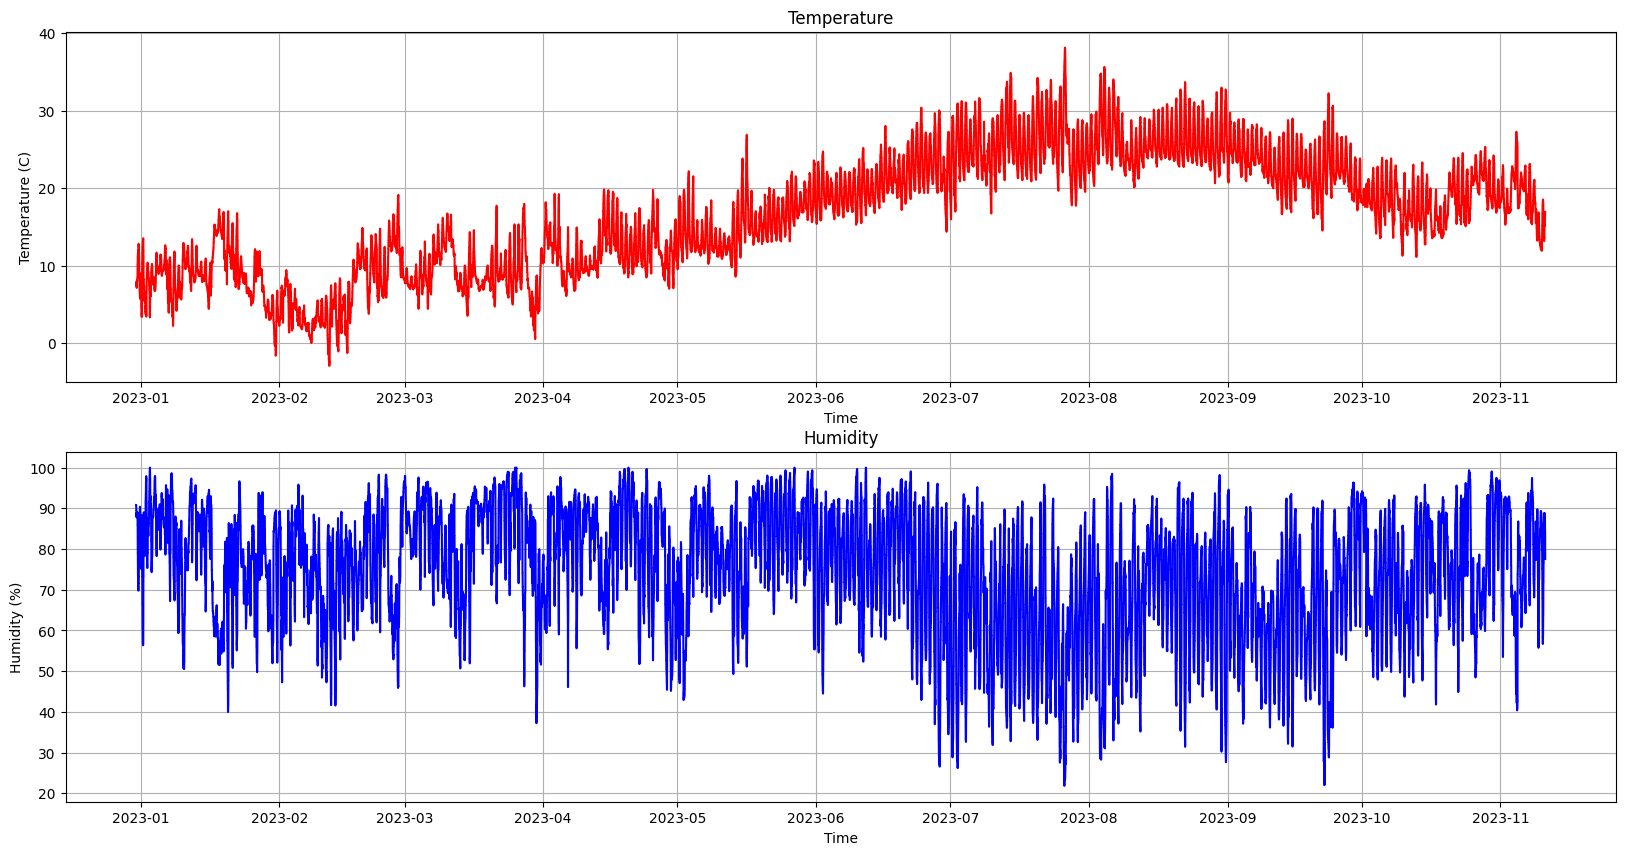

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

ax[0].plot(OUTLET_WEATHER_DATA['Timestamp'], OUTLET_WEATHER_DATA['Temperature'], color='red')
ax[0].set_title('Temperature')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Temperature (C)')
ax[0].grid()

ax[1].plot(OUTLET_WEATHER_DATA['Timestamp'], OUTLET_WEATHER_DATA['Humidity'], color='blue')
ax[1].set_title('Humidity')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Humidity (%)')
ax[1].grid()

plt.show()

## TRIALS

In [10]:
# Get the daily weather data
fetch_past_weather_data("2023-01-01", "2023-01-07", "daily")

Coordinates 41.01932907104492°E 28.887304306030273°N
Timezone b'Europe/Moscow' b'MSK'


,date,temperature_max,temperature_min,temperature_mean
0,2023-01-01 21:00:00,13.545500,3.395500,8.332999
1,2023-01-02 21:00:00,10.395500,3.445500,7.249667
2,2023-01-03 21:00:00,10.245500,3.345500,7.566332
3,2023-01-04 21:00:00,11.695499,6.795500,8.870500
4,2023-01-05 21:00:00,11.445499,8.695499,9.805917
5,2023-01-06 21:00:00,12.645500,8.895500,10.453834
6,2023-01-07 21:00:00,11.095500,3.945500,7.832999


In [11]:
# Get the hourly weather data
fetch_past_weather_data("2023-01-07", "2023-01-07", "hourly")

Coordinates 41.01932907104492°E 28.887304306030273°N
Timezone b'Europe/Moscow' b'MSK'


,date,temperature,relative_humidity
0,2023-01-06 22:00:00,10.095500,90.711075
1,2023-01-06 23:00:00,7.945500,94.688843
2,2023-01-07 00:00:00,6.945500,92.386322
3,2023-01-07 01:00:00,9.345500,81.532356
4,2023-01-07 02:00:00,7.895500,83.924690
5,2023-01-07 03:00:00,5.245500,90.044685
6,2023-01-07 04:00:00,5.795500,87.902481
7,2023-01-07 05:00:00,6.145500,87.627029
8,2023-01-07 06:00:00,4.195500,92.549095
9,2023-01-07 07:00:00,3.945500,93.192215


In [12]:
getWeatherForecast("minutely_15", forecast_days=1)

,date,temperature_2m,relative_humidity_2m
0,2023-11-25 21:15:00,17.65,56.0
1,2023-11-25 21:30:00,17.65,56.0
2,2023-11-25 21:45:00,17.65,56.0
3,2023-11-25 22:00:00,17.65,56.0
4,2023-11-25 22:15:00,17.65,56.0
...,...,...,...
283,2023-11-28 20:00:00,15.30,62.0
284,2023-11-28 20:15:00,15.30,62.0
285,2023-11-28 20:30:00,15.25,63.0
286,2023-11-28 20:45:00,15.20,64.0
